In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
def get_layer_embeddings(model, tokenizer, sentences, max_length=512):
    all_layers_embeddings = []
    for sentence in tqdm(sentences, desc="Processing sentences for embeddings"):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=max_length)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states = outputs.hidden_states
        embeddings = [state.squeeze(0).numpy() for state in hidden_states]
        all_layers_embeddings.append(embeddings)
    return all_layers_embeddings

# 2. Średnie podobieństwo kosinusowe losowych słów
def average_cosine_similarity(embeddings):
    avg_similarities = []
    num_layers = len(embeddings[0])
    for layer in tqdm(range(1, num_layers), desc="Calculating Average Cosine Similarity"):
        layer_vectors = [sentence[layer] for sentence in embeddings]
        random_sims = []
        for vecs in layer_vectors:
            idx1, idx2 = np.random.choice(len(vecs), 2, replace=False)
            random_sims.append(cosine_similarity(vecs[idx1:idx1+1], vecs[idx2:idx2+1])[0][0])
        avg_similarities.append(np.mean(random_sims))
    return avg_similarities

# 3. Self-similarity
def self_similarity(embeddings, baseline):
    self_sims = []
    num_layers = len(embeddings[0])
    for layer in tqdm(range(1, num_layers), desc="Calculating Self-Similarity"):
        layer_vectors = [sentence[layer] for sentence in embeddings]
        sims = []
        for vecs in layer_vectors:
            sim_matrix = cosine_similarity(vecs)
            mask = ~np.eye(sim_matrix.shape[0], dtype=bool)  # Usuń diagonal
            sims.append(sim_matrix[mask].mean())
        self_sims.append(np.mean(sims) - baseline[layer - 1])  # Korekta o baseline
    return self_sims

# 4. Intra-sentence similarity
def intra_sentence_similarity_gpu(embeddings, baseline, device='mps'):
    intra_sims = []
    num_layers = len(embeddings[0])
    
    for layer in tqdm(range(1, num_layers), desc="Calculating Intra-Sentence Similarity (GPU)"):
        layer_vectors = [torch.tensor(sentence[layer], device=device) for sentence in embeddings]
        sims = []
        
        for vecs in layer_vectors:
            sentence_mean = vecs.mean(dim=0)
            
            norm_vecs = vecs / vecs.norm(dim=1, keepdim=True)
            norm_mean = sentence_mean / sentence_mean.norm()
            
            similarities = torch.matmul(norm_vecs, norm_mean)
            
            sims.extend(similarities.cpu().numpy())
        
        intra_sims.append(np.mean(sims) - baseline[layer - 1])
    
    return intra_sims

# 5. Wykres
def plot_metric(layers, bert_metric, gpt2_metric, title, ylabel):
    gpt2_metric = gpt2_metric[:12]
    plt.figure(figsize=(12, 6))
    plt.plot(layers, bert_metric, label="BERT", marker='o')
    plt.plot(layers, gpt2_metric, label="GPT-2", marker='o')
    plt.title(title)
    plt.xlabel("Layer")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [3]:
dataset = load_dataset("clarin-knext/wsd_polish_datasets", split="train", trust_remote_code=True)
sample_texts = dataset["text"][:250]
len(sample_texts)

250

In [4]:
bert_model_name = "allegro/herbert-base-cased"
gpt2_model_name = "sdadas/polish-gpt2-medium"

In [5]:
bert_model = AutoModel.from_pretrained(bert_model_name, output_hidden_states=True)
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

gpt2_model = AutoModel.from_pretrained(gpt2_model_name, output_hidden_states=True)
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
print("Extracting embeddings for BERT...")
bert_embeddings = get_layer_embeddings(bert_model, bert_tokenizer, sample_texts)

print("Extracting embeddings for GPT-2...")
gpt2_embeddings = get_layer_embeddings(gpt2_model, gpt2_tokenizer, sample_texts)


Extracting embeddings for BERT...


Processing sentences for embeddings:   0%|          | 0/250 [00:00<?, ?it/s]

Processing sentences for embeddings: 100%|██████████| 250/250 [00:33<00:00,  7.45it/s]


Extracting embeddings for GPT-2...


Processing sentences for embeddings: 100%|██████████| 250/250 [02:12<00:00,  1.89it/s]


In [7]:
layers = list(range(1, len(bert_embeddings[0])))

print("Calculating baseline similarities...")
bert_baseline = average_cosine_similarity(bert_embeddings)
gpt2_baseline = average_cosine_similarity(gpt2_embeddings)

print("Calculating Average Cosine Similarity...")
bert_avg_cos_sim = bert_baseline
gpt2_avg_cos_sim = gpt2_baseline

print("Calculating Self-Similarity...")
bert_self_sim = self_similarity(bert_embeddings, bert_baseline)
gpt2_self_sim = self_similarity(gpt2_embeddings, gpt2_baseline)

print("Calculating Intra-Sentence Similarity...")
bert_intra_sim = intra_sentence_similarity_gpu(bert_embeddings, bert_baseline)
gpt2_intra_sim = intra_sentence_similarity_gpu(gpt2_embeddings, gpt2_baseline)

Calculating baseline similarities...


Calculating Average Cosine Similarity: 100%|██████████| 24/24 [00:01<00:00, 12.03it/s]


Calculating Average Cosine Similarity...
Calculating Self-Similarity...


Calculating Self-Similarity: 100%|██████████| 24/24 [01:26<00:00,  3.62s/it]


Calculating Intra-Sentence Similarity...


Calculating Intra-Sentence Similarity (GPU): 100%|██████████| 24/24 [00:51<00:00,  2.16s/it]


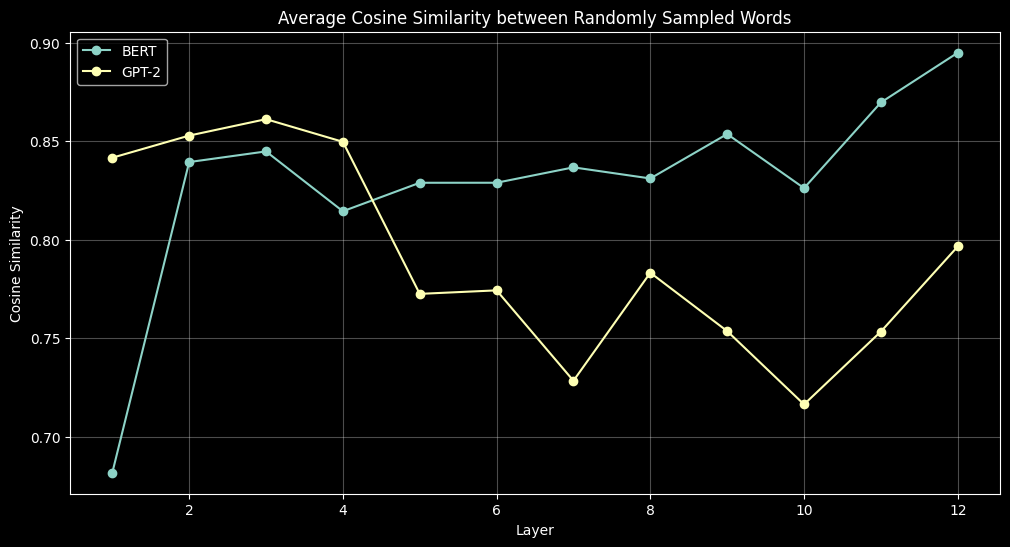

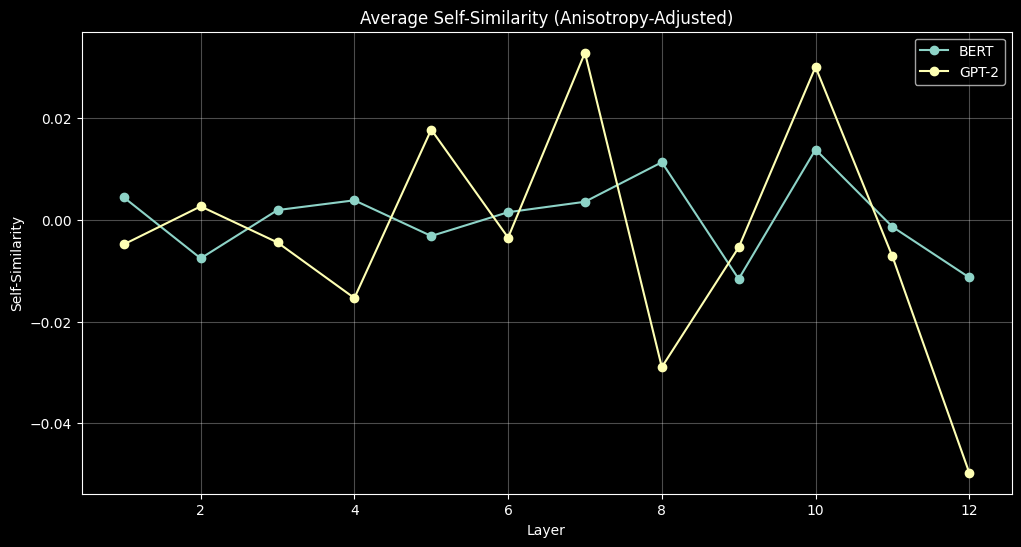

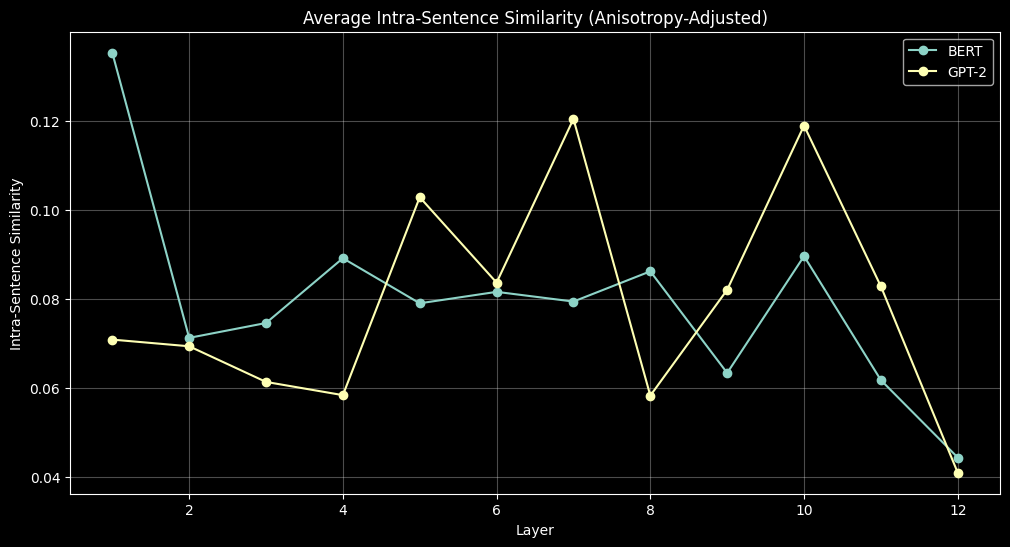

In [17]:
plot_metric(layers, bert_avg_cos_sim, gpt2_avg_cos_sim, "Average Cosine Similarity between Randomly Sampled Words", "Cosine Similarity")
plot_metric(layers, bert_self_sim, gpt2_self_sim, "Average Self-Similarity (Anisotropy-Adjusted)", "Self-Similarity")
plot_metric(layers, bert_intra_sim, gpt2_intra_sim, "Average Intra-Sentence Similarity (Anisotropy-Adjusted)", "Intra-Sentence Similarity")